# ResNet50 Performance Benchmarking
## PyTorch Native vs ONNX Runtime vs TensorRT

Comprehensive performance comparison across different inference backends:
1. **PyTorch Native** - CPU
2. **PyTorch Native** - GPU (CUDA)
3. **ONNX Runtime** - CPU
4. **ONNX Runtime** - GPU (CUDA)
5. **TensorRT** - GPU Engine

## Metrics
- Inference time (ms)
- Throughput (FPS)
- Latency statistics (mean, std, min, max)
- Speedup comparison
- Memory usage

## 1. Setup Environment

In [1]:
!nvidia-smi

Fri Jan 23 16:34:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   44C    P8             20W /  170W |    1440MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Tue_Dec_16_07:23:41_PM_PST_2025
Cuda compilation tools, release 13.1, V13.1.115
Build cuda_13.1.r13.1/compiler.37061995_0


In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q tensorrt==10.8.0.43 --extra-index-url https://pypi.nvidia.com
!pip install -q onnx onnxruntime-gpu onnxscript 
!pip install -q matplotlib seaborn pandas numpy pycuda

## 2. Import Libraries

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import onnx
import onnxruntime as ort
import numpy as np
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# Print versions and device info
print(f'PyTorch version: {torch.__version__}')
print(f'ONNX version: {onnx.__version__}')
print(f'ONNX Runtime version: {ort.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
print(f'ONNX Runtime providers: {ort.get_available_providers()}')

# Check TensorRT availability
try:
    import tensorrt as trt
    print(f'TensorRT version: {trt.__version__}')
    HAS_TENSORRT = True
except ImportError:
    print('TensorRT: Not installed')
    HAS_TENSORRT = False

PyTorch version: 2.7.1+cu118
ONNX version: 1.20.1
ONNX Runtime version: 1.23.2
CUDA available: True
CUDA version: 11.8
GPU device: NVIDIA GeForce RTX 3060
GPU memory: 12.48 GB
ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
TensorRT version: 10.8.0.43


## 3. Configuration

In [5]:
# Paths
ONNX_PATH = 'models/resnet50.onnx'
TENSORRT_PATH = 'models/resnet50.engine'

# Benchmark settings
IMG_SIZE = 224
BATCH_SIZE = 1
NUM_WARMUP = 50
NUM_RUNS = 500
OPSET_VERSION = 18

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print(f'Configuration:')
print(f'  Image size: {IMG_SIZE}x{IMG_SIZE}')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Warmup runs: {NUM_WARMUP}')
print(f'  Benchmark runs: {NUM_RUNS}')
print(f'  ONNX opset: {OPSET_VERSION}')

Configuration:
  Image size: 224x224
  Batch size: 1
  Warmup runs: 50
  Benchmark runs: 500
  ONNX opset: 18


## 4. Load PyTorch ResNet50

In [6]:
print('='*60)
print('Loading PyTorch ResNet50')
print('='*60)

# Load pre-trained ResNet50
pytorch_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
pytorch_model.eval()

# Count parameters
total_params = sum(p.numel() for p in pytorch_model.parameters())
print(f'Model loaded: ResNet50')
print(f'Total parameters: {total_params:,}')
print(f'Model size: ~{total_params * 4 / 1e6:.2f} MB (FP32)')

Loading PyTorch ResNet50
Model loaded: ResNet50
Total parameters: 25,557,032
Model size: ~102.23 MB (FP32)


## 5. Benchmark PyTorch Native - CPU

In [7]:
print('='*60)
print('Benchmarking PyTorch ResNet50 on CPU')
print('='*60)

# Move model to CPU
pytorch_model_cpu = pytorch_model.cpu()

# Create dummy input
dummy_input_cpu = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)

# Warmup
print(f'Warming up ({NUM_WARMUP} iterations)...')
for _ in range(NUM_WARMUP):
    with torch.no_grad():
        _ = pytorch_model_cpu(dummy_input_cpu)

# Benchmark
print(f'Benchmarking ({NUM_RUNS} iterations)...')
pytorch_cpu_times = []
for _ in tqdm(range(NUM_RUNS), desc='PyTorch CPU'):
    start = time.time()
    with torch.no_grad():
        _ = pytorch_model_cpu(dummy_input_cpu)
    pytorch_cpu_times.append((time.time() - start) * 1000)  # Convert to ms

# Calculate statistics
pytorch_cpu_results = {
    'mean': np.mean(pytorch_cpu_times),
    'std': np.std(pytorch_cpu_times),
    'min': np.min(pytorch_cpu_times),
    'max': np.max(pytorch_cpu_times),
    'fps': 1000.0 / np.mean(pytorch_cpu_times)
}

print(f'\nPyTorch CPU Results:')
print(f'  Mean: {pytorch_cpu_results["mean"]:.2f} ± {pytorch_cpu_results["std"]:.2f} ms')
print(f'  Min:  {pytorch_cpu_results["min"]:.2f} ms')
print(f'  Max:  {pytorch_cpu_results["max"]:.2f} ms')
print(f'  FPS:  {pytorch_cpu_results["fps"]:.2f}')

Benchmarking PyTorch ResNet50 on CPU
Warming up (50 iterations)...
Benchmarking (500 iterations)...


PyTorch CPU: 100%|██████████| 500/500 [00:15<00:00, 32.87it/s]


PyTorch CPU Results:
  Mean: 30.31 ± 1.70 ms
  Min:  29.11 ms
  Max:  37.56 ms
  FPS:  33.00


## 6. Benchmark PyTorch Native - GPU

In [8]:
if torch.cuda.is_available():
    print('='*60)
    print('Benchmarking PyTorch ResNet50 on GPU')
    print('='*60)
    
    # Move model to GPU
    pytorch_model_gpu = pytorch_model.cuda()
    dummy_input_gpu = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE).cuda()
    
    # Warmup
    print(f'Warming up ({NUM_WARMUP} iterations)...')
    for _ in range(NUM_WARMUP):
        with torch.no_grad():
            _ = pytorch_model_gpu(dummy_input_gpu)
    torch.cuda.synchronize()
    
    # Benchmark
    print(f'Benchmarking ({NUM_RUNS} iterations)...')
    pytorch_gpu_times = []
    for _ in tqdm(range(NUM_RUNS), desc='PyTorch GPU'):
        torch.cuda.synchronize()
        start = time.time()
        with torch.no_grad():
            _ = pytorch_model_gpu(dummy_input_gpu)
        torch.cuda.synchronize()
        pytorch_gpu_times.append((time.time() - start) * 1000)
    
    # Calculate statistics
    pytorch_gpu_results = {
        'mean': np.mean(pytorch_gpu_times),
        'std': np.std(pytorch_gpu_times),
        'min': np.min(pytorch_gpu_times),
        'max': np.max(pytorch_gpu_times),
        'fps': 1000.0 / np.mean(pytorch_gpu_times)
    }
    
    print(f'\nPyTorch GPU Results:')
    print(f'  Mean: {pytorch_gpu_results["mean"]:.2f} ± {pytorch_gpu_results["std"]:.2f} ms')
    print(f'  Min:  {pytorch_gpu_results["min"]:.2f} ms')
    print(f'  Max:  {pytorch_gpu_results["max"]:.2f} ms')
    print(f'  FPS:  {pytorch_gpu_results["fps"]:.2f}')
    print(f'  Speedup over CPU: {pytorch_cpu_results["mean"] / pytorch_gpu_results["mean"]:.2f}x')
else:
    print('⚠️  CUDA not available. Skipping GPU benchmark.')
    pytorch_gpu_results = None

Benchmarking PyTorch ResNet50 on GPU
Warming up (50 iterations)...
Benchmarking (500 iterations)...


PyTorch GPU: 100%|██████████| 500/500 [00:01<00:00, 343.12it/s]


PyTorch GPU Results:
  Mean: 2.90 ± 0.03 ms
  Min:  2.88 ms
  Max:  3.22 ms
  FPS:  345.24
  Speedup over CPU: 10.46x


## 7. Convert PyTorch to ONNX

In [9]:
print('='*60)
print('Converting PyTorch ResNet50 → ONNX')
print('='*60)

# Export to ONNX
dummy_input = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
torch.onnx.export(
    pytorch_model.cpu(),
    dummy_input,
    ONNX_PATH,
    export_params=True,
    opset_version=OPSET_VERSION,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

# Validate ONNX model
onnx_model = onnx.load(ONNX_PATH)
onnx.checker.check_model(onnx_model)

onnx_size_mb = os.path.getsize(ONNX_PATH) / (1024 * 1024)
print(f'✅ ONNX model saved: {ONNX_PATH}')
print(f'   Model size: {onnx_size_mb:.2f} MB')
print(f'   Opset version: {OPSET_VERSION}')

Converting PyTorch ResNet50 → ONNX
✅ ONNX model saved: models/resnet50.onnx
   Model size: 97.41 MB
   Opset version: 18


## 8. Benchmark ONNX Runtime - CPU

In [10]:
print('='*60)
print('Benchmarking ONNX Runtime on CPU')
print('='*60)

# Create ONNX Runtime session for CPU
sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

onnx_cpu_session = ort.InferenceSession(
    ONNX_PATH,
    providers=['CPUExecutionProvider'],
    sess_options=sess_options
)

input_name = onnx_cpu_session.get_inputs()[0].name
output_name = onnx_cpu_session.get_outputs()[0].name

# Create input
dummy_input_onnx = np.random.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

# Warmup
print(f'Warming up ({NUM_WARMUP} iterations)...')
for _ in range(NUM_WARMUP):
    _ = onnx_cpu_session.run([output_name], {input_name: dummy_input_onnx})

# Benchmark
print(f'Benchmarking ({NUM_RUNS} iterations)...')
onnx_cpu_times = []
for _ in tqdm(range(NUM_RUNS), desc='ONNX CPU'):
    start = time.time()
    _ = onnx_cpu_session.run([output_name], {input_name: dummy_input_onnx})
    onnx_cpu_times.append((time.time() - start) * 1000)

# Calculate statistics
onnx_cpu_results = {
    'mean': np.mean(onnx_cpu_times),
    'std': np.std(onnx_cpu_times),
    'min': np.min(onnx_cpu_times),
    'max': np.max(onnx_cpu_times),
    'fps': 1000.0 / np.mean(onnx_cpu_times)
}

print(f'\nONNX Runtime CPU Results:')
print(f'  Mean: {onnx_cpu_results["mean"]:.2f} ± {onnx_cpu_results["std"]:.2f} ms')
print(f'  Min:  {onnx_cpu_results["min"]:.2f} ms')
print(f'  Max:  {onnx_cpu_results["max"]:.2f} ms')
print(f'  FPS:  {onnx_cpu_results["fps"]:.2f}')
print(f'  Speedup over PyTorch CPU: {pytorch_cpu_results["mean"] / onnx_cpu_results["mean"]:.2f}x')

Benchmarking ONNX Runtime on CPU
Warming up (50 iterations)...
Benchmarking (500 iterations)...


ONNX CPU: 100%|██████████| 500/500 [00:05<00:00, 90.92it/s]


ONNX Runtime CPU Results:
  Mean: 10.94 ± 0.13 ms
  Min:  10.81 ms
  Max:  11.51 ms
  FPS:  91.37
  Speedup over PyTorch CPU: 2.77x


## 9. Benchmark ONNX Runtime - GPU

In [11]:
if 'CUDAExecutionProvider' in ort.get_available_providers():
    print('='*60)
    print('Benchmarking ONNX Runtime on GPU')
    print('='*60)
    
    # Create ONNX Runtime session for GPU
    onnx_gpu_session = ort.InferenceSession(
        ONNX_PATH,
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
        sess_options=sess_options
    )
    
    print(f'Execution providers: {onnx_gpu_session.get_providers()}')
    
    # Warmup
    print(f'Warming up ({NUM_WARMUP} iterations)...')
    for _ in range(NUM_WARMUP):
        _ = onnx_gpu_session.run([output_name], {input_name: dummy_input_onnx})
    
    # Benchmark
    print(f'Benchmarking ({NUM_RUNS} iterations)...')
    onnx_gpu_times = []
    for _ in tqdm(range(NUM_RUNS), desc='ONNX GPU'):
        start = time.time()
        _ = onnx_gpu_session.run([output_name], {input_name: dummy_input_onnx})
        onnx_gpu_times.append((time.time() - start) * 1000)
    
    # Calculate statistics
    onnx_gpu_results = {
        'mean': np.mean(onnx_gpu_times),
        'std': np.std(onnx_gpu_times),
        'min': np.min(onnx_gpu_times),
        'max': np.max(onnx_gpu_times),
        'fps': 1000.0 / np.mean(onnx_gpu_times)
    }
    
    print(f'\nONNX Runtime GPU Results:')
    print(f'  Mean: {onnx_gpu_results["mean"]:.2f} ± {onnx_gpu_results["std"]:.2f} ms')
    print(f'  Min:  {onnx_gpu_results["min"]:.2f} ms')
    print(f'  Max:  {onnx_gpu_results["max"]:.2f} ms')
    print(f'  FPS:  {onnx_gpu_results["fps"]:.2f}')
    print(f'  Speedup over PyTorch CPU: {pytorch_cpu_results["mean"] / onnx_gpu_results["mean"]:.2f}x')
    if pytorch_gpu_results:
        print(f'  Speedup over PyTorch GPU: {pytorch_gpu_results["mean"] / onnx_gpu_results["mean"]:.2f}x')
else:
    print('⚠️  CUDA Execution Provider not available. Skipping ONNX GPU benchmark.')
    onnx_gpu_results = None

Benchmarking ONNX Runtime on GPU
Execution providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Warming up (50 iterations)...
Benchmarking (500 iterations)...


ONNX GPU: 100%|██████████| 500/500 [00:01<00:00, 334.77it/s]


ONNX Runtime GPU Results:
  Mean: 2.97 ± 0.02 ms
  Min:  2.95 ms
  Max:  3.13 ms
  FPS:  336.17
  Speedup over PyTorch CPU: 10.19x
  Speedup over PyTorch GPU: 0.97x


## 10. Convert ONNX to TensorRT

In [12]:
if HAS_TENSORRT and torch.cuda.is_available():
    print('='*60)
    print('Converting ONNX → TensorRT Engine')
    print('='*60)
    
    import tensorrt as trt
    
    # TensorRT logger
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    
    # Build engine
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)
    
    # Parse ONNX
    print('Parsing ONNX model...')
    with open(ONNX_PATH, 'rb') as model_file:
        model_data = model_file.read()
        if not parser.parse(model_data):
            print('ERROR: Failed to parse ONNX file.')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            raise RuntimeError('Failed to parse ONNX model')
    
    print(f'✅ ONNX model parsed successfully')
    print(f'   Network inputs: {[network.get_input(i).name for i in range(network.num_inputs)]}')
    print(f'   Network outputs: {[network.get_output(i).name for i in range(network.num_outputs)]}')
    
    # Build config
    config = builder.create_builder_config()
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)  # 1GB
    
    # Create optimization profile for dynamic shapes
    profile = builder.create_optimization_profile()
    input_tensor = network.get_input(0)
    input_shape = input_tensor.shape
    
    print(f'   Input shape: {input_shape}')
    
    # Set optimization profile (min, opt, max) for dynamic batch dimension
    # Format: (batch, channels, height, width)
    min_shape = (1, 3, IMG_SIZE, IMG_SIZE)
    opt_shape = (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
    max_shape = (8, 3, IMG_SIZE, IMG_SIZE)  # Max batch size = 8
    
    profile.set_shape(input_tensor.name, min_shape, opt_shape, max_shape)
    config.add_optimization_profile(profile)
    
    print(f'✅ Optimization profile configured:')
    print(f'   Min shape: {min_shape}')
    print(f'   Opt shape: {opt_shape}')
    print(f'   Max shape: {max_shape}')
    
    # Enable FP16 if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)
        print('✅ FP16 mode enabled')
    else:
        print('⚠️  FP16 not supported, using FP32')
    
    # Build engine
    print('Building TensorRT engine (this may take a few minutes)...')
    print('  Optimizing network...')
    serialized_engine = builder.build_serialized_network(network, config)
    
    if serialized_engine is None:
        raise RuntimeError('Failed to build TensorRT engine')
    
    print('✅ Engine built successfully')
    
    # Save engine
    print(f'Saving engine to {TENSORRT_PATH}...')
    with open(TENSORRT_PATH, 'wb') as f:
        f.write(serialized_engine)
    
    trt_size_mb = os.path.getsize(TENSORRT_PATH) / (1024 * 1024)
    print(f'✅ TensorRT engine saved: {TENSORRT_PATH}')
    print(f'   Engine size: {trt_size_mb:.2f} MB')
else:
    if not HAS_TENSORRT:
        print('⚠️  TensorRT not installed. Skipping conversion.')
    else:
        print('⚠️  CUDA not available. Skipping TensorRT conversion.')

Converting ONNX → TensorRT Engine
Parsing ONNX model...
✅ ONNX model parsed successfully
   Network inputs: ['input']
   Network outputs: ['output']
   Input shape: (-1, 3, 224, 224)
✅ Optimization profile configured:
   Min shape: (1, 3, 224, 224)
   Opt shape: (1, 3, 224, 224)
   Max shape: (8, 3, 224, 224)
✅ FP16 mode enabled
Building TensorRT engine (this may take a few minutes)...
  Optimizing network...
✅ Engine built successfully
Saving engine to models/resnet50.engine...
✅ TensorRT engine saved: models/resnet50.engine
   Engine size: 51.38 MB


## 11. Benchmark TensorRT Engine

In [13]:
if HAS_TENSORRT and torch.cuda.is_available() and os.path.exists(TENSORRT_PATH):
    print('='*60)
    print('Benchmarking TensorRT Engine')
    print('='*60)
    
    import tensorrt as trt
    import pycuda.driver as cuda
    import pycuda.autoinit
    
    # TensorRT logger
    TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    
    # Load engine
    print('Loading TensorRT engine...')
    with open(TENSORRT_PATH, 'rb') as f:
        engine_data = f.read()
    
    runtime = trt.Runtime(TRT_LOGGER)
    engine = runtime.deserialize_cuda_engine(engine_data)
    context = engine.create_execution_context()
    
    print(f'Engine loaded successfully')
    print(f'  Number of I/O tensors: {engine.num_io_tensors}')
    
    # Get input/output tensor names
    input_name = engine.get_tensor_name(0)
    output_name = engine.get_tensor_name(1)
    print(f'  Input tensor: {input_name}')
    print(f'  Output tensor: {output_name}')
    
    # Set input shape for dynamic shape engine
    input_shape = (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
    context.set_input_shape(input_name, input_shape)
    
    # Verify all shapes are specified
    if not context.all_shape_inputs_specified:
        raise RuntimeError('Not all shape inputs were specified')
    
    # Get output shape after setting input shape
    output_shape = context.get_tensor_shape(output_name)
    print(f'  Input shape: {input_shape}')
    print(f'  Output shape: {output_shape}')
    
    # Allocate host buffers
    h_input = np.random.randn(*input_shape).astype(np.float32)
    h_output = np.empty(output_shape, dtype=np.float32)
    
    # Allocate device buffers
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    
    # Create CUDA stream
    stream = cuda.Stream()
    
    # Set tensor addresses
    context.set_tensor_address(input_name, int(d_input))
    context.set_tensor_address(output_name, int(d_output))
    
    # Warmup
    print(f'\nWarming up ({NUM_WARMUP} iterations)...')
    for _ in range(NUM_WARMUP):
        cuda.memcpy_htod_async(d_input, h_input, stream)
        context.execute_async_v3(stream_handle=stream.handle)
        cuda.memcpy_dtoh_async(h_output, d_output, stream)
        stream.synchronize()
    
    # Benchmark
    print(f'Benchmarking ({NUM_RUNS} iterations)...')
    tensorrt_times = []
    for _ in tqdm(range(NUM_RUNS), desc='TensorRT'):
        stream.synchronize()  # Ensure previous operations are complete
        start = time.time()
        cuda.memcpy_htod_async(d_input, h_input, stream)
        context.execute_async_v3(stream_handle=stream.handle)
        cuda.memcpy_dtoh_async(h_output, d_output, stream)
        stream.synchronize()
        tensorrt_times.append((time.time() - start) * 1000)
    
    # Calculate statistics
    tensorrt_results = {
        'mean': np.mean(tensorrt_times),
        'std': np.std(tensorrt_times),
        'min': np.min(tensorrt_times),
        'max': np.max(tensorrt_times),
        'fps': 1000.0 / np.mean(tensorrt_times)
    }
    
    print(f'\nTensorRT Results:')
    print(f'  Mean: {tensorrt_results["mean"]:.2f} ± {tensorrt_results["std"]:.2f} ms')
    print(f'  Min:  {tensorrt_results["min"]:.2f} ms')
    print(f'  Max:  {tensorrt_results["max"]:.2f} ms')
    print(f'  FPS:  {tensorrt_results["fps"]:.2f}')
    print(f'  Speedup over PyTorch CPU: {pytorch_cpu_results["mean"] / tensorrt_results["mean"]:.2f}x')
    if pytorch_gpu_results:
        print(f'  Speedup over PyTorch GPU: {pytorch_gpu_results["mean"] / tensorrt_results["mean"]:.2f}x')
    if onnx_gpu_results:
        print(f'  Speedup over ONNX GPU: {onnx_gpu_results["mean"] / tensorrt_results["mean"]:.2f}x')
    
    # Clean up
    del d_input, d_output, stream
else:
    print('⚠️  TensorRT engine not available. Skipping benchmark.')
    tensorrt_results = None

Benchmarking TensorRT Engine
Loading TensorRT engine...
Engine loaded successfully
  Number of I/O tensors: 2
  Input tensor: input
  Output tensor: output
  Input shape: (1, 3, 224, 224)
  Output shape: (1, 1000)

Warming up (50 iterations)...
Benchmarking (500 iterations)...


TensorRT: 100%|██████████| 500/500 [00:00<00:00, 1396.71it/s]


TensorRT Results:
  Mean: 0.71 ± 0.01 ms
  Min:  0.70 ms
  Max:  0.75 ms
  FPS:  1403.11
  Speedup over PyTorch CPU: 42.52x
  Speedup over PyTorch GPU: 4.06x
  Speedup over ONNX GPU: 4.17x


## 12. Comprehensive Comparison Table

In [14]:
print('\n' + '='*120)
print('COMPREHENSIVE PERFORMANCE COMPARISON: ResNet50')
print('='*120)

# Collect all results
results_dict = {
    'PyTorch CPU': pytorch_cpu_results,
    'PyTorch GPU': pytorch_gpu_results,
    'ONNX CPU': onnx_cpu_results,
    'ONNX GPU': onnx_gpu_results,
    'TensorRT': tensorrt_results
}

# Remove None values
results_dict = {k: v for k, v in results_dict.items() if v is not None}

# Print table
print(f'{"Backend":<20} {"Mean (ms)":<15} {"Std (ms)":<15} {"Min (ms)":<15} {"Max (ms)":<15} {"FPS":<15} {"Speedup":<15}')
print('-'*120)

baseline_time = pytorch_cpu_results['mean']
for name, res in results_dict.items():
    speedup = baseline_time / res['mean']
    print(f'{name:<20} {res["mean"]:<15.2f} {res["std"]:<15.2f} {res["min"]:<15.2f} {res["max"]:<15.2f} {res["fps"]:<15.2f} {speedup:<15.2f}x')

print('='*120)

# Best performer
best_backend = min(results_dict.items(), key=lambda x: x[1]['mean'])
print(f'\n🏆 Best Performance: {best_backend[0]} ({best_backend[1]["mean"]:.2f} ms, {best_backend[1]["fps"]:.2f} FPS)')
print(f'📊 Speedup over PyTorch CPU: {baseline_time / best_backend[1]["mean"]:.2f}x')


COMPREHENSIVE PERFORMANCE COMPARISON: ResNet50
Backend              Mean (ms)       Std (ms)        Min (ms)        Max (ms)        FPS             Speedup        
------------------------------------------------------------------------------------------------------------------------
PyTorch CPU          30.31           1.70            29.11           37.56           33.00           1.00           x
PyTorch GPU          2.90            0.03            2.88            3.22            345.24          10.46          x
ONNX CPU             10.94           0.13            10.81           11.51           91.37           2.77           x
ONNX GPU             2.97            0.02            2.95            3.13            336.17          10.19          x
TensorRT             0.71            0.01            0.70            0.75            1403.11         42.52          x

🏆 Best Performance: TensorRT (0.71 ms, 1403.11 FPS)
📊 Speedup over PyTorch CPU: 42.52x


## 13. Detailed Visualization

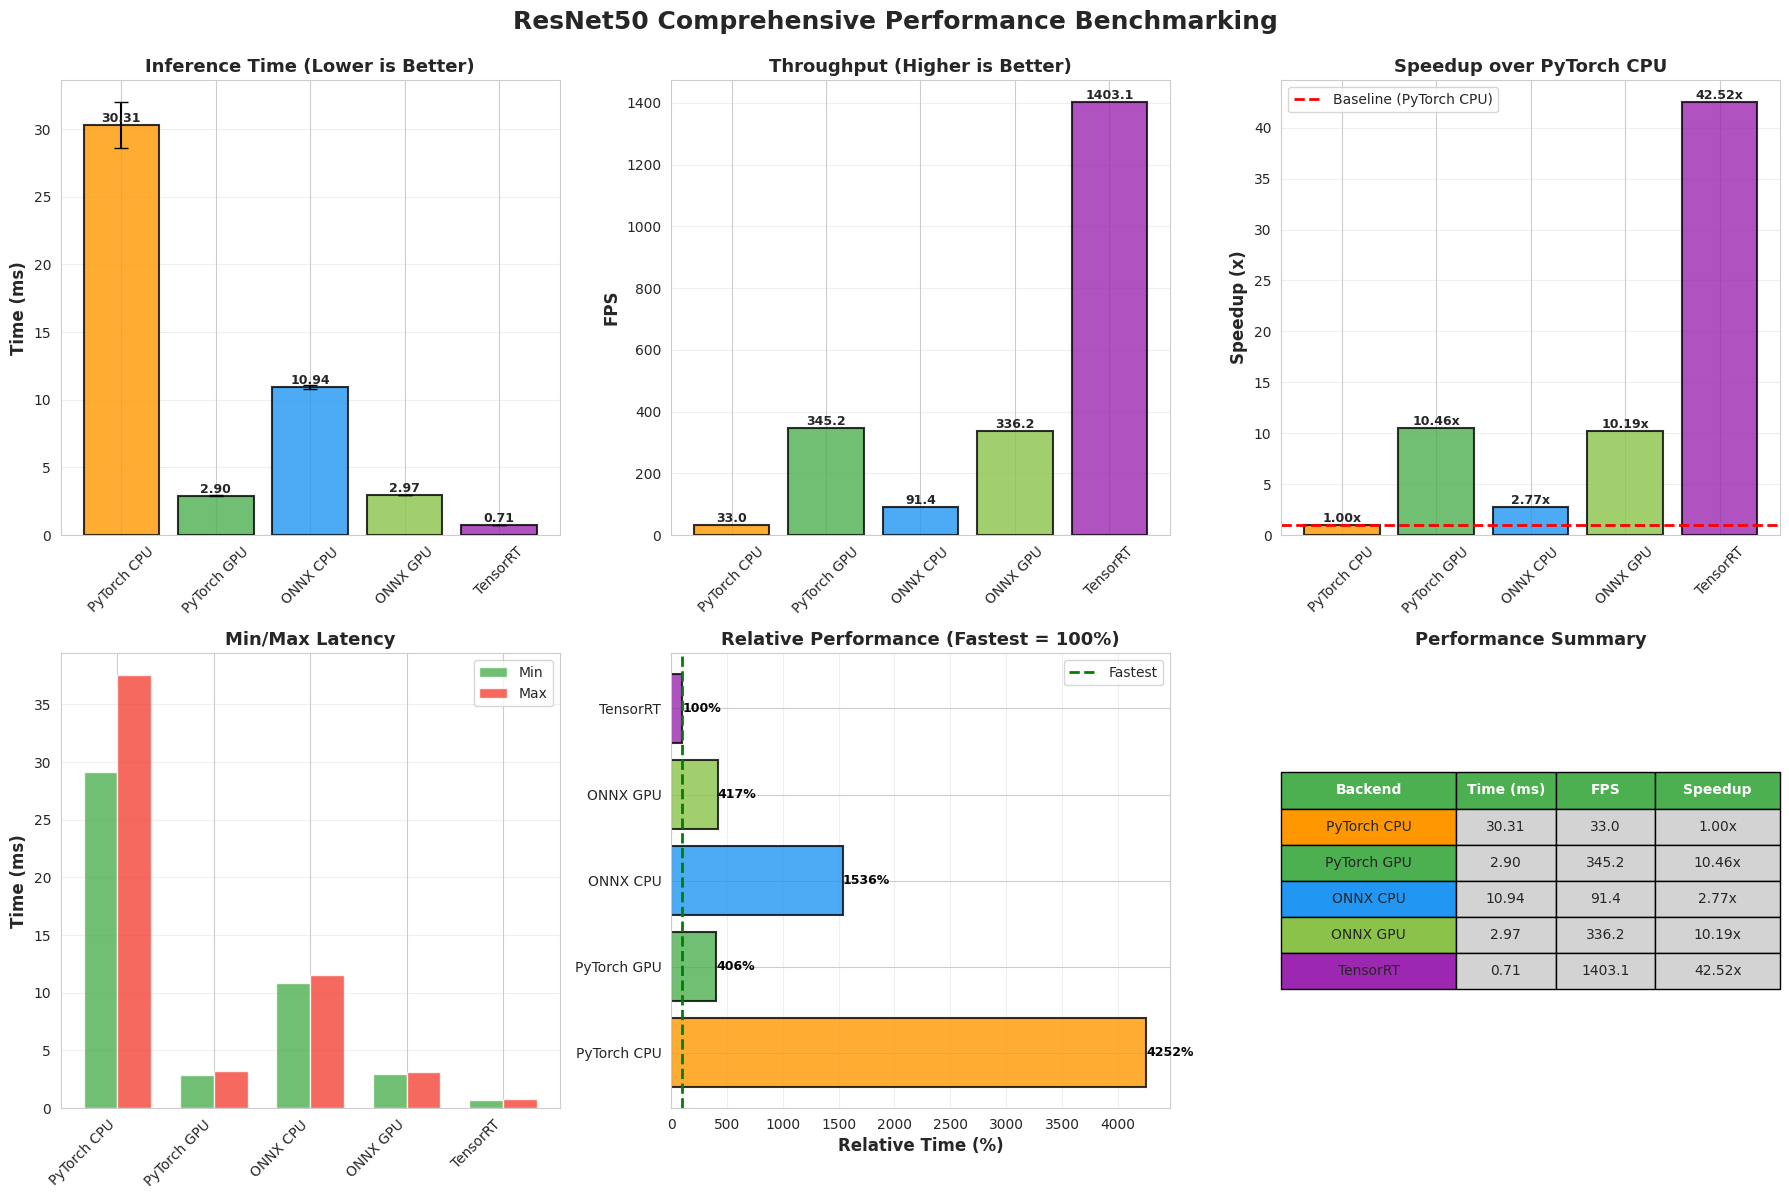


✅ Saved: results/resnet50_comprehensive_benchmark.png


In [15]:
# Prepare data for visualization
backend_names = list(results_dict.keys())
mean_times = [results_dict[b]['mean'] for b in backend_names]
std_times = [results_dict[b]['std'] for b in backend_names]
fps_values = [results_dict[b]['fps'] for b in backend_names]
speedups = [baseline_time / results_dict[b]['mean'] for b in backend_names]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ResNet50 Comprehensive Performance Benchmarking', fontsize=18, fontweight='bold', y=0.995)

# Define colors
colors = ['#FF9800', '#4CAF50', '#2196F3', '#8BC34A', '#9C27B0'][:len(backend_names)]

# 1. Inference Time (with error bars)
axes[0, 0].bar(backend_names, mean_times, yerr=std_times, color=colors, alpha=0.8, 
               capsize=5, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Inference Time (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, (name, time) in enumerate(zip(backend_names, mean_times)):
    axes[0, 0].text(i, time, f'{time:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Throughput (FPS)
bars = axes[0, 1].bar(backend_names, fps_values, color=colors, alpha=0.8, 
                      edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('FPS', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Throughput (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, fps in enumerate(fps_values):
    axes[0, 1].text(i, fps, f'{fps:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Speedup vs PyTorch CPU
bars = axes[0, 2].bar(backend_names, speedups, color=colors, alpha=0.8, 
                      edgecolor='black', linewidth=1.5)
axes[0, 2].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (PyTorch CPU)')
axes[0, 2].set_ylabel('Speedup (x)', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Speedup over PyTorch CPU', fontsize=13, fontweight='bold')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)
for i, speedup in enumerate(speedups):
    axes[0, 2].text(i, speedup, f'{speedup:.2f}x', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')

# 4. Min/Max Latency Comparison
min_times = [results_dict[b]['min'] for b in backend_names]
max_times = [results_dict[b]['max'] for b in backend_names]
x = np.arange(len(backend_names))
width = 0.35
axes[1, 0].bar(x - width/2, min_times, width, label='Min', color='#4CAF50', alpha=0.8)
axes[1, 0].bar(x + width/2, max_times, width, label='Max', color='#F44336', alpha=0.8)
axes[1, 0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Min/Max Latency', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(backend_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Relative Performance (normalized)
normalized = [100 * results_dict[b]['mean'] / min(mean_times) for b in backend_names]
bars = axes[1, 1].barh(backend_names, normalized, color=colors, alpha=0.8, 
                       edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Relative Time (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Relative Performance (Fastest = 100%)', fontsize=13, fontweight='bold')
axes[1, 1].axvline(x=100, color='green', linestyle='--', linewidth=2, label='Fastest')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)
for i, val in enumerate(normalized):
    axes[1, 1].text(val, i, f'{val:.0f}%', ha='left', va='center', 
                    fontsize=9, fontweight='bold', color='black')

# 6. Summary Table
table_data = []
for name in backend_names:
    res = results_dict[name]
    table_data.append([
        name,
        f"{res['mean']:.2f}",
        f"{res['fps']:.1f}",
        f"{baseline_time / res['mean']:.2f}x"
    ])

axes[1, 2].axis('tight')
axes[1, 2].axis('off')
table = axes[1, 2].table(
    cellText=table_data,
    colLabels=['Backend', 'Time (ms)', 'FPS', 'Speedup'],
    cellLoc='center',
    loc='center',
    colWidths=[0.35, 0.2, 0.2, 0.25]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
# Color rows
for i in range(len(table_data)):
    for j in range(4):
        table[(i+1, j)].set_facecolor(colors[i] if j == 0 else 'lightgray')
axes[1, 2].set_title('Performance Summary', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('results/resnet50_comprehensive_benchmark.png', dpi=300, bbox_inches='tight')
plt.show()
print('\n✅ Saved: results/resnet50_comprehensive_benchmark.png')